In [1]:
# Import libraries for data manipulation and numerical operations
import pandas as pd
import numpy as np
import math

# Import NLTK for Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Download necessary NLTK datasets
nltk.download('punkt')  # Tokenizers
nltk.download('stopwords')  # Stopwords for removing common words
nltk.download('wordnet')  # Lexical database for lemmatization
nltk.download('averaged_perceptron_tagger')  # Part-of-speech tagger
nltk.download('omw-1.4')  # Extended wordnet dataset

# Import TextBlob for sentiment analysis
from textblob import TextBlob

# Import scikit-learn modules for data preprocessing and similarity computation
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# Safe evaluation of literal expressions
from ast import literal_eval

# Import visualization tools
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import seaborn as sns
import string

# Initialize the WordNet Lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Import NetworkX for network analysis
import networkx as nx

# Import bipartite graph algorithms from NetworkX
from networkx.algorithms import bipartite

# Additional imports for plotting and creating counters
import matplotlib.pyplot as plt
from collections import Counter

from community import community_louvain

%matplotlib inline

[nltk_data] Downloading package punkt to /Users/irene/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/irene/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/irene/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/irene/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /Users/irene/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Table of Contents

[0. Preamble](#0.-Preamble)  
[1. About the data](#1.-About-the-data)
      [1.1. Data Loading and Preprocessing](#1.1.-Data-Loading-and-Preprocessing)  
      [1.2. Data Exploration](#1.2.-Data-Exploration)  
[2. Sentiment Analysis](#2.-Sentiment-Analysis)  
      [2.1. Overview Preprocessing](#2.1.-Overview-Preprocessing)  
      [2.2. Sentiment score: polarity](#2.2.-Sentiment-score:-polarity)  
      [2.3. Sentiment Analysis: Sentiment Trends Over Time](#2.3.-Sentiment-Analysis:-Sentiment-Trends-Over-Time)  
      [2.4. Sentiment Analysis: Genre-Based Sentiment Analysis](#2.4.-Sentiment-Analysis:-Genre-Based-Sentiment-Analysis)  
      [2.5. Sentiment Analysis: Original Movie Language and Sentiment Analysis](#2.5.-sentiment-analysis-original-movie-language-and-sentiment-analysis)  
      [2.6. Sentiment Analysis: Runtime and Sentiment](#2.6.-sentiment-analysis-runtime-and-sentiment)  
      [2.7. Sentiment Analysis: Sentiment Analysis: Sentiment and Movie ratings](#27-sentiment-analysis-sentiment-and-movie-ratings)  
      [2.8. Sentiment Analysis: WordClouds - overview](#28-wordclouds---overview)  
      [2.9. Sentiment Analysis: Discussion](#29-sentiment-analysis-discussion)  
[3. Recommendation System](#3-content-based-recommendation-system)  
      [3.1. Content Based Recommender 1](#31-content-based-recommender-1-recommends-movies-based-on-a-favorite-movie)  
      [3.2. Content Based Recommender 2](#32-content-based-recommender-2-recommends-movies-based-on-a-list-of-favorite-movies)  
      [3.3. Collaborative Recommendation System](#31-content-based-recommender-1-recommends-movies-based-on-a-favorite-movie)  
[4. Movies Network](#4-movies-network)  
      [4.1. Movies Network Visualization](#41-movies-network-visualization)  
      [4.2. Movies Network Analysis](#42-movies-network-analysis)  

# 0. Preamble

This notebook is an integral part of our final project for the Computational Tools for Data Science course at DTU. 

A key application of our analysis is in the realm of recommendation systems. By integrating sentiment analysis, we aim to enhance the personalization of these systems. For instance, if a user prefers movies with positive or uplifting themes, our system will utilize sentiment analysis to identify movies that align with these preferences. We will analyze various movie features, including genres, original language, runtime, release date, and movie overviews. 

The ultimate goal is to develop a recommendation system that captures the heart and soul of movies, as a true movie lover.

⚠️ This notebook will not include detailed explanations for each line of code in the text, since the code is thoroughly commented for clarity :)

# 1. About the data

We consider the [Full MovieLens Dataset](https://grouplens.org/datasets/movielens/), featuring approximately $45,000$ movies released on or before July 2017. 

## 1.1. Data Loading and Preprocessing

We begin by importing and cleaning three datasets: `movies_metadata.csv`, `credits.csv`, and `ratings.csv`. These are the datasets we will be using on our analysis.

Below are the functions used for importing and initial processing of these datasets.

In [2]:
''' useful functions to load and clean the data '''

# Function to import and process the movies metadata
def import_movies_metadata(csv_movies_metadata):
    """
    Imports and processes the movies metadata CSV file into a pandas DataFrame.

    Parameters:
    - csv_movies_metadata (str): File path to the movies metadata CSV file.

    Returns:
    - movies_metadata (DataFrame): Processed movies metadata Pandas DataFrame.
    """
    # Read the movies metadata CSV file
    movies_metadata = pd.read_csv(csv_movies_metadata, low_memory=False, encoding='utf-8')

    # Select relevant columns for analysis
    movies_metadata = movies_metadata[['id', 'title', 'overview', 'genres', 'original_language', 'release_date', 'runtime', 'popularity']]

    # Drop rows with NaN values to ensure data quality
    movies_metadata = movies_metadata.dropna()

    # Convert the 'genres' column from JSON format to a list of genre names
    movies_metadata['genres'] = movies_metadata['genres'].apply(literal_eval).apply(lambda x: [genre['name'] for genre in x])

    # Add a 'decade' column derived from the 'release_date' for easier categorization of movies by release decade
    movies_metadata['decade'] = (movies_metadata['release_date'].str.split('-').str[0].astype(int) // 10) * 10 

    # Ensure correct data types for 'id' and 'original_language'
    movies_metadata['id'] = movies_metadata['id'].astype(int)
    movies_metadata['original_language'] = movies_metadata['original_language'].astype(str)

    return movies_metadata

# Function to import and process movie credits data
def import_credits(csv_credits):
    """
    Imports and processes the movie credits CSV file into a pandas DataFrame.

    Parameters:
    - csv_credits (str): File path to the movie credits CSV file.

    Returns:
    - credits (DataFrame): Processed movie credits Pandas DataFrame.
    """
    # Read the 'credits' CSV file
    credits = pd.read_csv(csv_credits, low_memory=False, encoding='utf-8')

    # Keep only the 'id' and 'cast' columns and drop any rows with missing values
    credits = credits[['id', 'cast']].dropna()

    # Convert the 'cast' column from JSON format to a list of actor names
    credits['cast'] = credits['cast'].apply(literal_eval).apply(lambda x: [cast['name'] for cast in x])

    # Ensure the 'id' column is of integer type
    credits['id'] = credits['id'].astype(int)

    return credits

# Function to import and process movie ratings data
def import_ratings(cvs_ratings):
    """
    Imports and processes the movie ratings CSV file into a pandas DataFrame.

    Parameters:
    - cvs_ratings (str): File path to the movie ratings CSV file.

    Returns:
    - ratings (DataFrame): Processed movie ratings Pandas DataFrame.
    """
    # Read the 'ratings' CSV file
    ratings = pd.read_csv(cvs_ratings)

    # Keep only the 'movieId', 'userId', and 'rating' columns, and drop rows with missing values
    ratings = ratings[['movieId', 'userId', 'rating']].dropna()

    # Ensure the 'movieId' and 'userId' columns are of integer type
    ratings['movieId'] = ratings['movieId'].astype(int)
    ratings['userId'] = ratings['userId'].astype(int)

    # Rename columns for consistency and clarity
    ratings.rename(columns={'movieId': 'id', 'userId': 'user'}, inplace=True)

    return ratings

We import the data and get the summary statistics for each dataset.

In [3]:
''' import the data '''

# Import movies metadata using the previously defined function
movies_metadata = import_movies_metadata('the-movies-dataset/movies_metadata.csv')

# Print the size and column names of the movies metadata DataFrame
print(f'size = {len(movies_metadata)}')
print(f"column names: {', '.join(movies_metadata.columns)}\n")

# Import movie credits data using the previously defined function
credits = import_credits('the-movies-dataset/credits.csv')
# credits = import_credits('/Users/dimi/Machine Learning/ComputationalTools/ProjectFolder/the-movies-dataset/credits.csv')

# Print the size and column names of the credits DataFrame
print(f'size = {len(credits)}')
print(f"column names: {', '.join(credits)}\n")

# Importing movie ratings data using the previously defined function
ratings = import_ratings('the-movies-dataset/ratings.csv')
# ratings = import_ratings('/Users/dimi/Machine Learning/ComputationalTools/ProjectFolder/the-movies-dataset/ratings.csv')

# Print the size and column names of the ratings DataFrame
print(f'size = {len(ratings)}')
print(f"column names: {', '.join(ratings)}")
# Prints the number of unique movies and reviewers
print(f"number of movies = {ratings['id'].nunique()}")
print(f"number of reviewers = {ratings['user'].nunique()}")

size = 44425
column names: id, title, overview, genres, original_language, release_date, runtime, popularity, decade

size = 45476
column names: id, cast

size = 26024289
column names: id, user, rating
number of movies = 45115
number of reviewers = 270896


After preprocessing, the dataframes are structured as follows:

- **movies_metadata** (size: $44,425$)
    - `id`: Unique identifier for each movie.
    - `title`: Title of the movie.
    - `overview`: Brief description of the movie.
    - `genres`: Genres of the movie.
    - `original_language`: The language in which the movie was originally made.
    - `release_date`: Release date of the movie.
    - `runtime`: Length of the movie in minutes.
    - `decade`: Decade in which the movie was released.
- **credits** (size: $45,476$)
    - `id`: Unique identifier for each movie.
    - `cast`: List of actors.
- **ratings** (size: $26,024,289$)
   - `id`: Unique identifier for each movie. (number of movies = $45,115$)
    - `user`: Identifier for the user who rated the movie. (number of revieweres = $270,896$)*
    - `rating`: Rating given. between $1,0$ (bad) and $5,0$ (good) and an increment of $0,5$.

We will use these datasets in the next sections of the notebook and do further processing when needed.

$*$ Every user has reviewed multiple movies, hence each reviewer is present more than once in the data set.

## 1.2. Data Exploration

Let us inspect the head of these dataframes.

In [4]:
# Display the first 5 rows of the movies_metadata dataframe
movies_metadata.head(5)

id                        title  \
0    862                    Toy Story   
1   8844                      Jumanji   
2  15602             Grumpier Old Men   
3  31357            Waiting to Exhale   
4  11862  Father of the Bride Part II   

                                            overview  \
0  Led by Woody, Andy's toys live happily in his ...   
1  When siblings Judy and Peter discover an encha...   
2  A family wedding reignites the ancient feud be...   
3  Cheated on, mistreated and stepped on, the wom...   
4  Just when George Banks has recovered from his ...   

                         genres original_language release_date  runtime  \
0   [Animation, Comedy, Family]                en   1995-10-30     81.0   
1  [Adventure, Fantasy, Family]                en   1995-12-15    104.0   
2             [Romance, Comedy]                en   1995-12-22    101.0   
3      [Comedy, Drama, Romance]                en   1995-12-22    127.0   
4                      [Comedy]                en   1995-02-10    106.0   

  popularity  decade  
0  21.946943    1990  
1  17.015539    1990  
2    11.7129    1990  
3   3.859495    1990  
4   8.387519    1990

In [5]:
# Display the first 5 rows of the credits dataframe
credits.head(5)

id                                               cast
0    862  [Tom Hanks, Tim Allen, Don Rickles, Jim Varney...
1   8844  [Robin Williams, Jonathan Hyde, Kirsten Dunst,...
2  15602  [Walter Matthau, Jack Lemmon, Ann-Margret, Sop...
3  31357  [Whitney Houston, Angela Bassett, Loretta Devi...
4  11862  [Steve Martin, Diane Keaton, Martin Short, Kim...

In [6]:
# Display the first 5 rows of the ratings dataframe
ratings.head(5)

id  user  rating
0   110     1     1.0
1   147     1     4.5
2   858     1     5.0
3  1221     1     5.0
4  1246     1     5.0

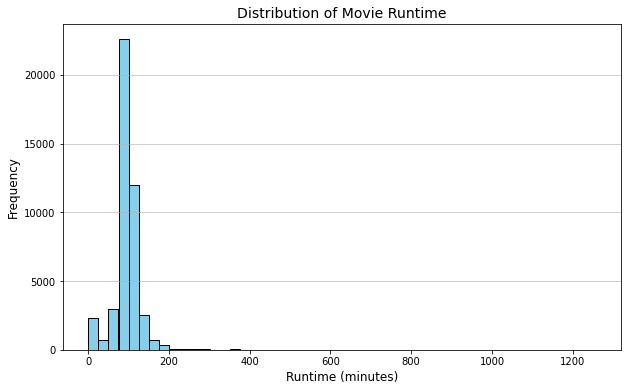

In [7]:
# Plot the distribution of Movie Runtime
plt.figure(figsize=(10, 6)) 
plt.hist(movies_metadata['runtime'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Runtime', fontsize=14) 
plt.xlabel('Runtime (minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [8]:
# Plot Distribution of Movie Ratings

# Define the bin edges to align with rating categories
bin_edges = [i * 0.5 for i in range(11)]  # Creates bins like [0, 0.5, 1, ..., 4.5, 5]

plt.figure(figsize=(10, 6))
plt.hist(ratings['rating'], bins=bin_edges, color='skyblue', edgecolor='black', align='left')
plt.title('Distribution of Ratings', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(bin_edges, fontsize=10)  # Set x-ticks to the bin edges
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.75)

plt.show()

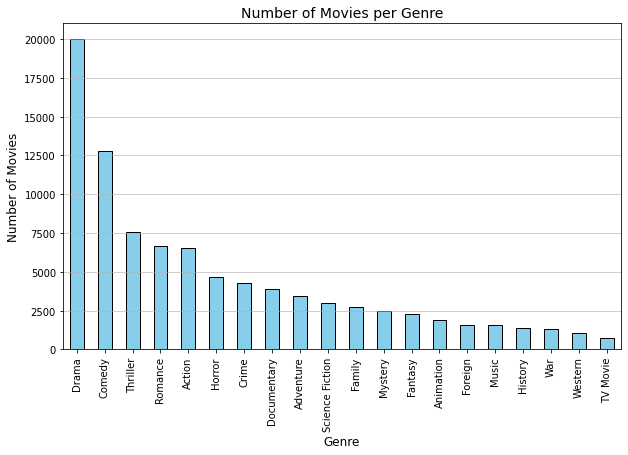

In [9]:
# Plot for Number of Movies per Genre
plt.figure(figsize=(10, 6))
genre_counts = movies_metadata['genres'].explode().value_counts()
genre_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Movies per Genre', fontsize=14)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.75)
plt.show()

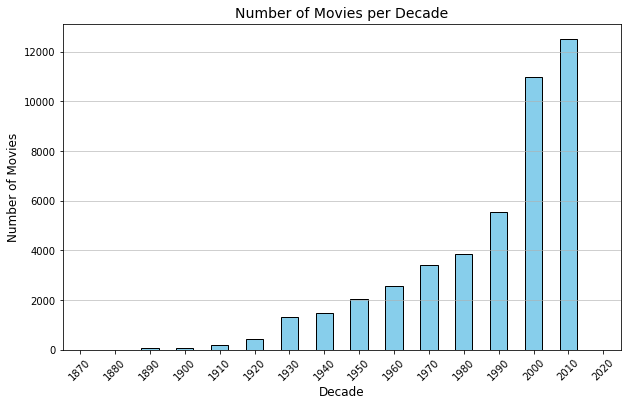

In [10]:
# Plot for Number of Movies per Decade
plt.figure(figsize=(10, 6))
decade_counts = movies_metadata['decade'].value_counts().sort_index()
decade_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Movies per Decade', fontsize=14)
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=45, fontsize=10)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.75)
plt.show()

# 2. Sentiment Analysis

We will do sentiment analysis on the movie overviews. Movie overviews often aim to encapsulate the essence of the film's story, including its emotional undertones. Sentiment analysis can help identify whether the tone of the overview is positive, negative, or neutral, which can be indicative of the movie's mood.

For the sentiment analysis, we will consider the `movies_metadata` dataframe loaded before, but we will add a new column `average_rating`. We calculate the `average_rating` for each movie by averaging the rating given by the users for each movie in the `ratings` dataframe. 

In [11]:
# Group by 'id' and calculate the mean rating for each movie
average_ratings = ratings.groupby('id')['rating'].mean().reset_index()

# Rename the 'rating' column to 'average_rating'
average_ratings.rename(columns={'rating': 'average_rating'}, inplace=True)

# Merge 'movies_metadata' and 'average_ratings' DataFrames on the 'id' column
movies_metadata = pd.merge(movies_metadata, average_ratings, on='id').dropna()

movies_metadata.head(5)

id             title                                           overview  \
0   862         Toy Story  Led by Woody, Andy's toys live happily in his ...   
1  8844           Jumanji  When siblings Judy and Peter discover an encha...   
2   949              Heat  Obsessive master thief, Neil McCauley leads a ...   
3   710         GoldenEye  James Bond must unmask the mysterious head of ...   
4  1408  Cutthroat Island  Morgan Adams and her slave, William Shaw, are ...   

                             genres original_language release_date  runtime  \
0       [Animation, Comedy, Family]                en   1995-10-30     81.0   
1      [Adventure, Fantasy, Family]                en   1995-12-15    104.0   
2  [Action, Crime, Drama, Thriller]                en   1995-12-15    170.0   
3     [Adventure, Action, Thriller]                en   1995-11-16    130.0   
4               [Action, Adventure]                en   1995-12-22    119.0   

  popularity  decade  average_rating  
0  21.946943    1990        3.598930  
1  17.015539    1990        3.760163  
2  17.924927    1990        3.905544  
3  14.686036    1990        2.740334  
4   7.284477    1990        3.710181

In the context of movie overviews, which essentially summarize the plots and themes of films, focusing primarily on the **polarity** score is the most relevant way to analyze sentiment.

Polarity directly measures whether the language in a movie overview is positive, negative, or neutral, likely reflecting the movie’s tone and mood. Thus, it can be indicative of genre and style: different genres tend to have distinct emotional tones (e.g., comedies might lean towards positive polarity, while horror or drama might have a negative polarity). We will analyze in this section how genres and polarity are correlated.

We could also analyze other sentiment scores, such as subjectivity, but focusing on polarity simplifies the analysis process. It provides a single, clear metric that can be easily interpreted and applied. When recommending movies based on user preferences, polarity can be a straightforward way to align recommendations with users' mood preferences.

Polarity scores range from $-1$ (very negative) to $1$ (very positive), with $0$ being neutral.

In our project, we use TextBlob to analyze each movie overview. By examining these scores, we hope to understand the overall sentiment of the movie.

## 2.1. Text Preprocessing 

Before calculating the _polarity_ scores of movie overviews, essential preprocessing steps are necessary to prepare the text. These steps include tokenization, stop words removal, POS-tagging, and lemmatization. Each step plays a critical role in ensuring that the text is accurately analyzed.

**Tokenization**

Tokenization is a crucial step in Natural Language Processing (NLP), where text is split into individual words, known as tokens. This process transforms a sequence of characters into a sequence of tokens, effectively breaking down sentences, paragraphs, or entire documents into their constituent words. For instance, "I hate exams" becomes `['I', 'hate', 'exams']`.

**Stop words removal**

Stop words removal is a key step in text preprocessing for Natural Language Processing (NLP). Stop words are common words like 'the', 'I', 'and', which typically don't contribute to the sentiment or meaningful analysis of the text. Considered as 'useless data', their removal ensures that analysis focuses on more significant words, enhancing efficiency and effectiveness. Python's Natural Language Toolkit (NLTK) offers an extensive list of stopwords in multiple languages, which can be easily accessed and utilized for stop word removal.

**POS-tag**

Part-Of-Speech (POS) tagging is an essential step in Natural Language Processing (NLP) and involves labeling each word in a sentence with its appropriate grammatical category, such as noun, verb, adjective, etc. This process, typically performed after tokenization, is crucial for understanding the role of each word in a sentence. POS tags are vital for subsequent NLP tasks like lemmatization, which reduces words to their root forms. The tagging process in Python is facilitated by the Natural Language Toolkit (NLTK).

**Lemmatization**

Lemmatization is a process in text processing where different forms of a word are converted to a single, basic form. This is helpful because it treats words with similar meanings as the same, regardless of their tense or case. For example, the words 'running', 'ran', and 'runs' all stem from the base word 'run'. Lemmatization identifies this base word and uses it to represent all its variations, making it easier to analyze the text. Essentially, it simplifies words to their core meaning. The output of the lemmatize function gives the final dataset of words which will be the input data for the sentiment analysis.

In [12]:
def process_overview(overview):
    """
    Tokenizes, removes stopwords, applies POS-tagging, and lemmatizes the input overview.

    Parameters:
    - overview (str): The text to be processed.

    Returns:
    - str: The processed and lemmatized overview.
    """

    # Dictionary for part-of-speech tagging
    pos_dict = {'J': wordnet.ADJ, 'V': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV}

    wordnet_lemmatizer = WordNetLemmatizer()
    # Tokenize and POS-tag
    tags = pos_tag(word_tokenize(overview))
    
    lemmatized_text = ""
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            # Get the POS tag for lemmatization
            pos = pos_dict.get(tag[0])
            # Lemmatize the word with POS tag
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos) if pos else word
            lemmatized_text += " " + lemma

    return lemmatized_text.strip()

We apply the function for tokenization, stop words removal, POS-tagging and lemmatization to the `overview` of the movies and we save the processed text as the column `processed_overview`. We explore the `overview` and `processed_overview` of a few movies.

In [13]:
movies_metadata['processed_overview'] = movies_metadata['overview'].apply(process_overview)

movies_metadata[['overview', 'processed_overview']].head(5)

overview  \
0  Led by Woody, Andy's toys live happily in his ...   
1  When siblings Judy and Peter discover an encha...   
2  Obsessive master thief, Neil McCauley leads a ...   
3  James Bond must unmask the mysterious head of ...   
4  Morgan Adams and her slave, William Shaw, are ...   

                                  processed_overview  
0  Led Woody , Andy 's toy live happily room Andy...  
1  sibling Judy Peter discover enchant board game...  
2  Obsessive master thief , Neil McCauley lead to...  
3  James Bond must unmask mysterious head Janus S...  
4  Morgan Adams slave , William Shaw , quest reco...

## 2.2. Sentiment score: polarity

In [14]:
''' functions to get the polarity score of an overview '''

def get_polarity(overview):
        return TextBlob(overview).sentiment.polarity

We calculate the polarity score for each movie overview in the `movies_metadata` dataframe and we save the score as new columns in the dataframe. We explore the , `overview`, `preocessed_overview`, and `polarity` of a few movies.

In [15]:
movies_metadata['polarity'] = movies_metadata['processed_overview'].apply(get_polarity)

movies_metadata[['overview', 'processed_overview', 'polarity']].head(5)

overview  \
0  Led by Woody, Andy's toys live happily in his ...   
1  When siblings Judy and Peter discover an encha...   
2  Obsessive master thief, Neil McCauley leads a ...   
3  James Bond must unmask the mysterious head of ...   
4  Morgan Adams and her slave, William Shaw, are ...   

                                  processed_overview  polarity  
0  Led Woody , Andy 's toy live happily room Andy...  0.112121  
1  sibling Judy Peter discover enchant board game... -0.265000  
2  Obsessive master thief , Neil McCauley lead to... -0.041667  
3  James Bond must unmask mysterious head Janus S...  0.000000  
4  Morgan Adams slave , William Shaw , quest reco... -0.180000

Let us analyse the sentiment polarity distribution, by using an histogram to visualize the polarity distribution across the dataset.

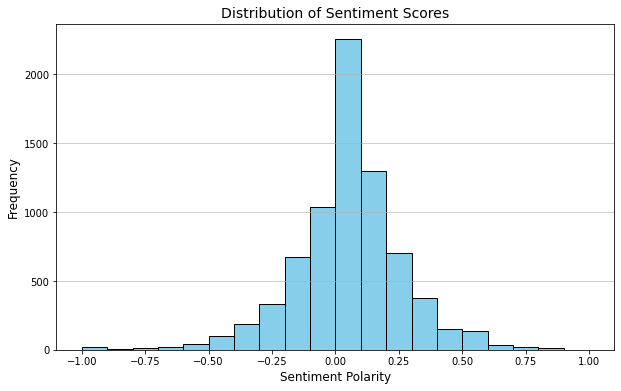

In [16]:
data = movies_metadata['polarity']

# Setting up the plot
plt.figure(figsize=(10, 6))  # Adjusting figure size
plt.hist(data, bins=np.arange(min(data), max(data) + 0.1, 0.1), color='skyblue', edgecolor='black')  # Histogram with specified bin size and color
plt.title('Distribution of Sentiment Scores', fontsize=14)
plt.xlabel('Sentiment Polarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(axis='y', alpha=0.75)

plt.show()

Let us analyze the plot above.

**KEY OBSERVATIONS OF THE POLARITY SCORE DISTRIBUTION**

**Peak at Neutral Sentiment:** A significant proportion of films have a slightly positive sentiment, as indicated by the highest frequency between the $0$-$0.1$ sentiment polarity.

**Asymmetrical Distribution:** There is a slight but discernible trend where bars on the right side (positive sentiment) are consistently taller than their corresponding left-side counterparts (negative sentiment), even though the bars on both sides of the neutral point are fairly equally distributed.

**INTERPRETATION**

The dataset's majority of movies may be rated as being slightly positive emotionally or as having a balanced combination of positive and negative aspects, based on the peak at $0$-$0.1$ sentiment polarity. Even though it is slight, the higher frequency of films on the positive side of the sentiment scale points to a general trend in the dataset towards more positive sentiments. This may indicate a tendency in the sentiment analysis tool to classify content as mildly positive, or it may reflect a trend in the film industry to create content with a slightly positive tone.

All in all, the sentiment score distribution shows a slight skew towards positive sentiment, but overall, we can say that neutral to slightly positive sentiment is prevalent across the films. This bias may be a result of the sentiment analysis technique employed or the type of movies included in the dataset.

## 2.3. Sentiment Analysis: Sentiment Trends Over Time

The average sentiment of films released since 1870 is shown as a line graph in this analysis, with sentiment values ranging from -1 (very negative) to +1 (highly positive), and 0 (neutral).

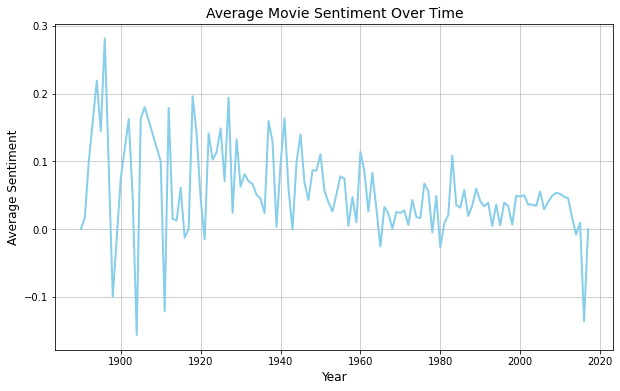

In [17]:
import matplotlib.pyplot as plt

# Convert 'release_date' to datetime and grab the year
movies_metadata['release_date'] = pd.to_datetime(movies_metadata['release_date'], errors='coerce')
movies_metadata['release_year'] = movies_metadata['release_date'].dt.year

# Group by release year and calculate the average sentiment
yearly_sentiment = movies_metadata.groupby('release_year')['polarity'].mean()

# Setting up the plot
plt.figure(figsize=(10, 6))
yearly_sentiment.plot(kind='line', color='skyblue', linewidth=2)
plt.title('Average Movie Sentiment Over Time', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.75)

plt.show()

Let us analyze the plot above. The historical period covered is from 1870 to 2020. The **average** sentiment fluctuations range widely, from approximately $-0.15$ to nearly $0.3$.

**Time Period: 1870-1920**

* **Sentiment Fluctuations:** The wstide range years, with average sentiment values ranging from $-0.15$ to almost $0.3$.

* **General Trend:** Mostly positive but with occasional dips below zero.

* **Notable Feature:** Frequent and significant fluctuations.

**Potential Explanations for Observed Trends**

* **film Evolution:** The early days of film were one of experimentation, which resulted in a wide range of opinions. Consistent opinion emerged as the film business became more homogenized after 1920.

* **Historical Context:** The emotions depicted in the film were impacted by varying society moods and concerns throughout history.

* **Genre and Audience Preferences:** The general sentiment patterns may have been impacted by shifts in popular genres and audience preferences over time.

**Historical Period: 1920–2020**

* **Emotional Variations:** Reduced scope , ranging roughly from $-0.02$ to $0.2$ for the most part. However there is a sudden dip below $0$ and until $-0.15$ after 2015 coming back to neutral sentiment at 2020.

* **Overall Trend:** Positive and almost constantly above zero.

* **Notable Feature:** Lower fluctuation than in the previous time frame.

**Potential Explanations for Observed Trends**

* **film Evolution:** The early days of film were one of experimentation, which resulted in a wide range of opinions. Consistent opinion emerged as the film business became more homogenized after 1920.

* **Historical Context:** The emotions depicted in the film were impacted by varying society moods and concerns throughout history (like World War I).

* **Genre and Audience Preferences:** Shifts throughout time in popular genres and audience preferences may have an impact on the overall sentiment trends.

## 2.4. Sentiment Analysis: Genre-Based Sentiment Analysis

In [18]:
# Explode the genres column into separate rows
exploded_df = movies_metadata.explode('genres')

# Group by genre and calculate the average sentiment score
average_sentiment = exploded_df.groupby('genres')['polarity'].mean()

plt.figure(figsize=(10, 8))
average_sentiment.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Polarity Score by Movie Genre', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Average Sentiment Score', fontsize=14)
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.75)

plt.savefig('average_sentiment_by_genre.png', dpi=300, format='png', transparent=True)

plt.show()

Let us analyze the plot above. A bar plot displaying the average sentiment score for each movie genre is presented in this analysis. The dataset's different genres are listed on the x-axis, while the average sentiment is represented on the y-axis.

#### Graph Explanation
* **Negative Sentiment Genres:** The average sentiment scores for the science fiction, horror, and thriller genres are below zero, indicating a general lack of positive sentiment in these genres.

* **Genres with Slightly Positive Sentiment:** The mystery, action and crime genres show an overall mildly negative sentiment, with average sentiment scores just below zero.

* **Very Positive Sentiment Genres:** The genres with the highest sentiment scores, well above zero, are music, comedy, romance, animation, and family. This indicates that these genres are very positive.

#### Analysis and Observations
##### Negative Sentiments in Some Genres:
* **Horror, Thriller, and Science Fiction:** These genres frequently have dramatic, gripping, or dystopian themes, which inevitably evoke negative emotions. For example, horror and thriller films emphasize tension and terror, whereas science fiction may have dystopian or uncertain themes.

##### Positive Sentiments in Other Genres:
* **Family, Animation, Comedy, Romance, and Music:**  Although these genres frequently deal with somber or suspenseful subjects, they also frequently have intriguing and satisfying elements, which could lead to an overall slightly optimistic feeling.

##### Mildly Positive Genres:
* **Mystery and Crime:** These genres are frequently linked to themes that are upbeat, humorous, or endearing. Animation and family films frequently target a younger audience and convey positive themes. Comedies are intended to make people laugh and feel good. Due in part to their frequent exploration of themes of joy and love, the romance and music genres have higher sentiment scores.

#### Conclusion
The underlying themes and emotional tenor that are commonly associated with various film genres are reflected in the sentiment scores of those genres. While genres linked to suspense, fear, or dystopian elements show lower, frequently negative sentiment scores, genres known for lighter, more uplifting themes tend to have higher positive sentiment scores.

## 2.5. Sentiment Analysis: Original Movie Language and Sentiment Analysis

The average sentiment score by language in movies is shown in a horizontal bar plot by this analysis. The average sentiment scores are displayed on the x-axis, which ranges from roughly -0.4 (very negative) to 0.3 (quite positive), while the y-axis lists various languages that can be found in the dataframe.

#### Graph Explanation
* **Languages with High Sentiment Scores:** Languages with the highest average sentiment scores close to 0.3 and below include Biulgarian, Telulu, Estonian, Ukrainian, Afrikaans, and Mongolian etc.

* **Languages with Low Sentiment Scores:** Languages with the lowest sentiment scores, approximately -0.4 and and above, include Marathi, Basque, Croatian, Indonesian, Bosnian etc.

* **European Languages:** Prominent European languages continuously display average sentiment scores that are higher than zero, reaching as high as 0.1.

#### Analysis and Observations
##### High and Low Sentiment Scores in Less Common Languages:
* **Varieties of Themes:** Films produced in languages such as Afrikaans, Ukrainian, or Mongolian may explore a variety of subjects, such as cultural quirks that often elicit strong emotional reactions. These could be folklore, cultural festivals, or themes of resiliency and victory that raise sentiment scores.

* **Restricted Sample Quantity:** The sample size of movies may be smaller for languages that are not as widely spoken or not as widely eccepted by the greater population. Because fewer movies will be skewing the average, this could result in more extreme average sentiment scores.

* **Separate Narrative Techniques:** Different narrative motifs and storytelling customs in these languages may naturally elicit more intense emotional reactions, either favorable or negative.

#### Consistent Moderate Sentiment in European Languages:
* **Wide Variety of Genres and Themes:** European language movies frequently feature a broad variety of genres and subjects. Because the positive and negative sentiments from various genres balance each other out, this diversity may result in a sentiment average that is more balanced.

* **Mainstream Appeal:** Movies with popular European languages may aim to appeal to a wider global viewership, which could result in themes and storylines that are less intensely emotional but still quite relatable.

* **Censorship and Industry Standards:** It's possible that censorship and commercial standards have a greater influence on the European film industry, resulting in more moderately impactful content.

#### Conclusion
Cultural themes, narrative styles, the number of films in each language, the target audience, and other factors may all have an impact on the variance in average sentiment scores amongst languages in movies. Well-known European languages tend to have more moderate sentiment scores than less commonly spoken languages, presumably as a result of their varied thematic content and wider appeal to a global audience.

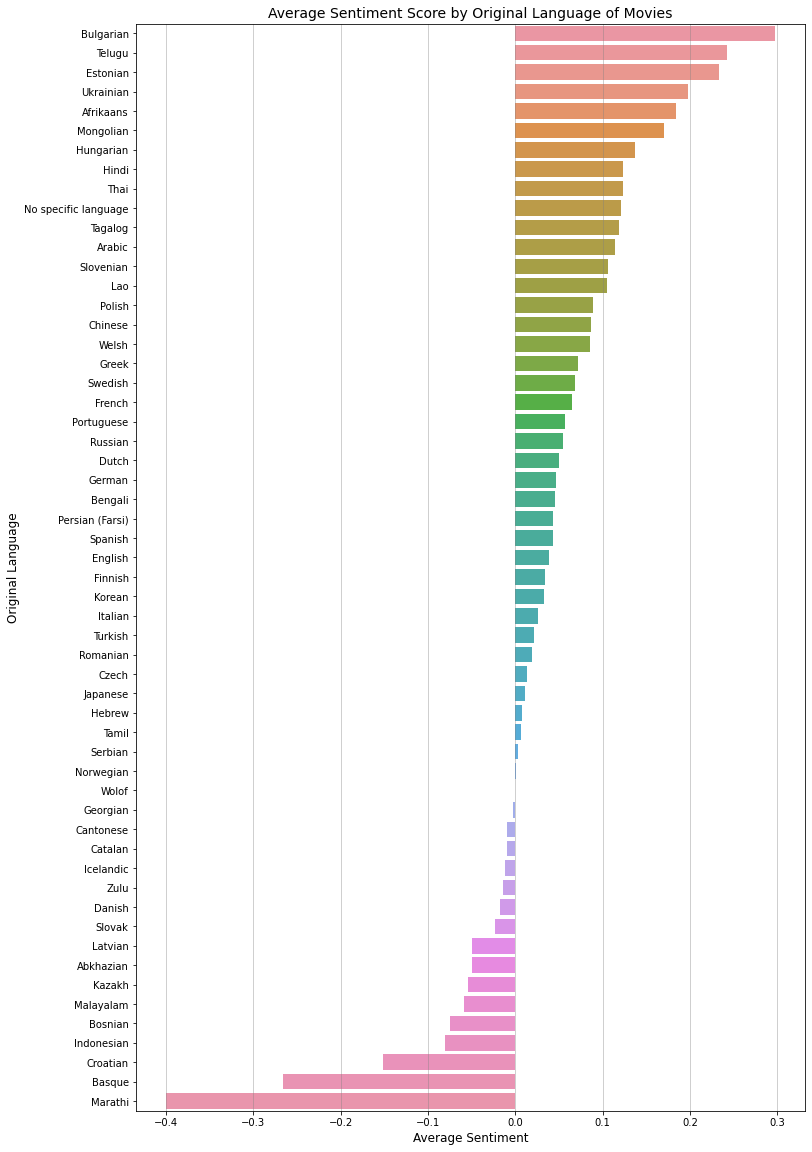

In [19]:
unique_values = movies_metadata['original_language'].unique()

language_dict = {
    'en': 'English', 'fr': 'French', 'zh': 'Chinese', 'it': 'Italian', 'fa': 'Persian (Farsi)',
    'nl': 'Dutch', 'de': 'German', 'cn': 'Cantonese', 'ar': 'Arabic', 'es': 'Spanish',
    'ru': 'Russian', 'ja': 'Japanese', 'sv': 'Swedish', 'ko': 'Korean', 'sr': 'Serbian',
    'bn': 'Bengali', 'pt': 'Portuguese', 'wo': 'Wolof', 'ro': 'Romanian', 'hu': 'Hungarian',
    'cy': 'Welsh', 'vi': 'Vietnamese', 'cs': 'Czech', 'da': 'Danish', 'no': 'Norwegian',
    'nb': 'Norwegian Bokmål', 'pl': 'Polish', 'el': 'Greek', 'sh': 'Serbo-Croatian', 'xx': 'No specific language',
    'mk': 'Macedonian', 'bo': 'Tibetan', 'ca': 'Catalan', 'fi': 'Finnish', 'th': 'Thai',
    'sk': 'Slovak', 'bs': 'Bosnian', 'he': 'Hebrew', 'hi': 'Hindi', 'tr': 'Turkish',
    'is': 'Icelandic', 'ps': 'Pashto', 'ab': 'Abkhazian', 'eo': 'Esperanto', 'ka': 'Georgian',
    'mn': 'Mongolian', 'bm': 'Bambara', 'zu': 'Zulu', 'uk': 'Ukrainian', 'af': 'Afrikaans','la': 'Latin', 'et': 'Estonian', 'ku': 'Kurdish', 'fy': 'Frisian', 'lv': 'Latvian', 'ta': 'Tamil',
    'sl': 'Slovenian', 'tl': 'Tagalog', 'ur': 'Urdu', 'rw': 'Kinyarwanda', 'id': 'Indonesian', 'bg': 'Bulgarian',
    'mr': 'Marathi', 'lt': 'Lithuanian', 'kk': 'Kazakh', 'ms': 'Malay', 'sq': 'Albanian', 'qu': 'Quechua',
    'te': 'Telugu', 'am': 'Amharic', 'jv': 'Javanese', 'tg': 'Tajik', 'ml': 'Malayalam', 'hr': 'Croatian',
    'lo': 'Lao', 'ay': 'Aymara', 'kn': 'Kannada', 'eu': 'Basque', 'ne': 'Nepali', 'pa': 'Punjabi',
    'ky': 'Kyrgyz', 'gl': 'Galician', 'uz': 'Uzbek', 'sm': 'Samoan', 'mt': 'Maltese', 'hy': 'Armenian',
    'iu': 'Inuktitut', 'lb': 'Luxembourgish', 'si': 'Sinhala'
}

# Grouping by original language and calculating the average sentiment
language_sentiment = movies_metadata.groupby('original_language')['polarity'].mean()

# Sorting the results for better visualization
language_sentiment_sorted = language_sentiment.sort_values(ascending=False)

# Replacing short language codes with full names after sorting
language_sentiment_sorted.index = language_sentiment_sorted.index.map(language_dict.get)

plt.figure(figsize=(12, 20))
sns.barplot(x=language_sentiment_sorted.values, y=language_sentiment_sorted.index)
# Setting title and labels with specified font sizes
plt.title('Average Sentiment Score by Original Language of Movies', fontsize=14)
plt.xlabel('Average Sentiment', fontsize=12)
plt.ylabel('Original Language', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', color='grey', linestyle='-', linewidth=0.5, alpha=0.75)

plt.show()

## 2.6. Sentiment Analysis: Runtime and Sentiment

#### Key Findings
* **Correlation Coefficient:** There is no discernible linear relationship between runtime and sentiment polarity, with a very low correlation (0.0037).

* **Distribution of Scatter Plots:** Points are mirror-like across various runtimes, and regardless of length, the majority of films are clustered between -0.5 and 0.5 in sentiment polarity.

#### Implications
 * **The Limited Impact of Runtime:** A film's sentiment polarity is not greatly affected by its runtime. This implies that other elements, like story structure or subject matter, have a greater influence on a movie's overall mood.
 
 * **Equipped Sentiment Spectrum:** For both short and long films, the sentiment polarity clusters within a moderate range suggest a general trend in filmmaking towards balanced emotional content.

#### Conclusion
The data demonstrates that sentiment polarity is not significantly influenced by the length of a film. The equitable dispersion of emotions throughout different runtimes suggests a constant style of emotional narrative in movies, regardless of their duration.

Correlation between runtime and sentiment: 0.003714323151867864


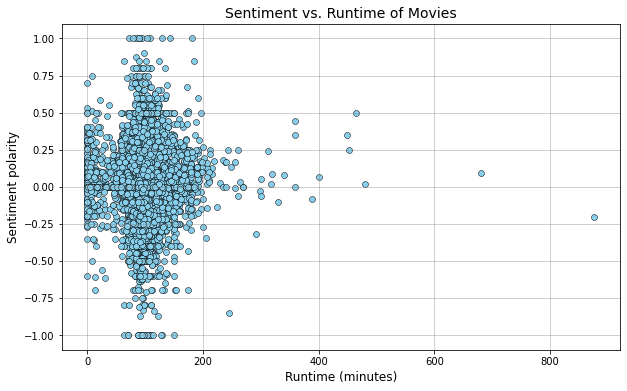

In [20]:
# Assuming movies_metadata is already loaded and contains the necessary columns

# Converting 'runtime' to numeric (if it's not already).
movies_metadata['runtime'] = pd.to_numeric(movies_metadata['runtime'], errors='coerce')

# Dropping rows with missing 'runtime' or 'polarity' values
movies_metadata.dropna(subset=['runtime', 'polarity'], inplace=True)

# Calculating the correlation between runtime and sentiment
correlation = movies_metadata['runtime'].corr(movies_metadata['polarity'])
print(f"Correlation between runtime and sentiment: {correlation}")

# Setting up the scatter plot
plt.figure(figsize=(10, 6)) 
sns.scatterplot(data=movies_metadata, x='runtime', y='polarity', color='skyblue', edgecolor='black')  # Scatter plot with specified color and edge color
plt.title('Sentiment vs. Runtime of Movies', fontsize=14)
plt.xlabel('Runtime (minutes)', fontsize=12)
plt.ylabel('Sentiment polarity', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.75)

plt.show()

## 2.7. Sentiment Analysis: Sentiment and Movie ratings

* A very weak negative correlation, roughly - 0.011, is revealed by analyzing the scatter plot and correlation coefficient between sentiment polarity and movie ratings in our dataset. This implies that there is little to no correlation between a film's rating and how positive or negative the sentiment is within it. The majority of the data points in the scatter plot are grouped in the center, with sentiment scores ranging from -0.6 to 0.6 and ratings between 2 and 4. This centering indicates that the majority of films have ratings that are in the middle range and display sentiment scores that are neutral to slightly positive or negative.

* The scatter plot's lack of a distinct pattern or directional trend highlights the weak correlation and suggests that factors other than sentiment polarity also have an impact on movie ratings. Ratings may be greatly impacted by elements like cast, genre, production value, marketing, and directing style. This study sheds light on the intricate nature of the relationship between sentiment and ratings, indicating that it may not be linear and may be impacted by a number of interrelated factors. As a result, even though sentiment analysis offers some insights, it is not a very reliable indicator of movie ratings. This suggests that more sophisticated or nuanced analytical models are required in order to fully comprehend movie ratings.

In [21]:
# Assuming movies_metadata is already loaded and contains the necessary columns

# Convert 'rating' to numeric, handling any non-numeric values as NaN
movies_metadata['average_rating'] = pd.to_numeric(movies_metadata['average_rating'], errors='coerce')

# Drop rows where either polarity or rating is NaN
movies_metadata.dropna(subset=['polarity', 'average_rating'], inplace=True)

# Calculating the correlation between sentiment (polarity) and movie ratings
correlation = movies_metadata['polarity'].corr(movies_metadata['average_rating'])
print(f"Correlation between sentiment (polarity) and movie ratings: {correlation}")

# Setting up the scatter plot
plt.figure(figsize=(10, 6))  # Adjusting figure size to match your other plots
sns.scatterplot(data=movies_metadata, x='average_rating', y='polarity', color='skyblue', edgecolor='black')  # Scatter plot with specified color and edge color
plt.title('Sentiment polarity vs. Movie Ratings', fontsize=14)
plt.xlabel('Movie Ratings', fontsize=12)
plt.ylabel('Sentiment polarity', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.75)

plt.show()

Correlation between sentiment (polarity) and movie ratings: -0.011154409482630677


## 2.8. WordClouds - overview

* By creating Word clouds from the overvies of different genres we discovered distinct patterns that reflect genre-specific themes in our word cloud analysis for various movie genres. The Horror genre's word cloud, for example, prominently features words like "crime," "murder," "detective," and "criminal," all of which are closely associated with horror films and highlight their focus on suspense and crime-related narratives.

* In addition, our research showed that terms like "find," "one," "life," "world," "year," and "family" were used in a variety of genres. These words encapsulate universal themes found plenty in storytelling and speak to a wide range of listeners. Their recurrent presence in word clouds across various genres highlights their significance in film narratives, as they embody fundamental components of human experiences and storytelling. This understanding gained from the word cloud results aids in identifying the recurrent themes and components that appeal to audiences in a variety of film genres.

In [22]:
exploded_genres = movies_metadata.explode('genres')
genre_overviews = exploded_genres.groupby('genres')['overview'].apply(' '.join)
num_genres = len(genre_overviews)
num_cols = 2
num_rows = math.ceil(num_genres / num_cols)

# Setting up the figure size to be large, as word clouds need more space
plt.figure(figsize=(20, 40))  

for i, (genre, overview) in enumerate(genre_overviews.items(), 1):
    wordcloud = WordCloud(width=800, height=800, background_color='white', contour_color='skyblue', contour_width=2).generate(overview)
    
    plt.subplot(num_rows, num_cols, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(genre, fontsize=20)  # Adjusting title font size for consistency
    plt.axis('off')  # Turning off the axis as it's not needed for word clouds

plt.tight_layout()
plt.show()

## 2.9. Sentiment Analysis: Discussion

#### What Went Well?
* **Comprehensive Analysis:** The project successfully carried out a comprehensive sentiment analysis across multiple dimensions, including sentiment trends over time, genre-based analysis, language impact, runtime correlations, and a comparison with movie ratings. This all-encompassing approach provided a multidimensional understanding of movie sentiment.

* **Insightful Observations:** The analysis produced insightful findings. We discovered patterns such as the evolution of film sentiment over time, genre influences on sentiment, and the diversity of sentiment expressions across languages. These findings contribute to our understanding of how emotion is depicted in films.
 
* **Data Utilization:** The dataset proved to be quite informative and versatile, allowing us to investigate a wide range of movie-related hypotheses. The availability of various data points such as genre, runtime, and language allowed for a more comprehensive analysis.

* **Technological Implementation:** Key trends and correlations were effectively highlighted by the use of sophisticated data analysis and visualization tools, such as word clouds for genre-based analysis and scatter plots for comparative analysis.

#### Areas for Improvement
* **Correlation Analysis:** Given the extremely low correlation between sentiment polarity and movie ratings, it would be advantageous to add more variables to our analysis model or use more sophisticated analytical methods. This could offer a more sophisticated comprehension of the variables impacting movie scores.

* **Sentiment Analysis Technique:** Although the sentiment analysis yielded insightful information, the methodology could be improved. More sophisticated natural language processing techniques or contextual sentiment analysis, for example, may produce more accurate sentiment interpretations, particularly when it comes to capturing the nuances and subtleties in narratives.



# 3. Recommendation Systems

## 3. Content-based Recommendation System

A content-based recommendation system is a type of filter that utilizes a range of features associated with items (in our case, movies) to recommend additional items similar to what a user likes, based on their past preferences.

We will create two types of content-based recommenders:

- **Content-based Recommender System 1:** This system recommends movies similar to a specific movie the user loves. By analyzing features such as plot descriptions, genres, runtime, release decades, and sentiment polarity (derived from movie overviews), it finds movies that share a close resemblance with the user's favorite.
- **Content-based Recommender System 2:** Taking it a step further, this system incorporates the sentiment polarity alongside other features. It considers a list of the user's favorite movies and recommends new movies that align with the collective attributes of the user's favorites, including the overall sentiment conveyed in their plot descriptions.

These systems aim to deliver a more nuanced and personalized movie recommendation experience by considering not just the tangible movie features but also the underlying sentiment, offering a unique blend of quantitative and qualitative analysis.

## 3.1. CONTENT BASED RECOMMENDER 1: Recommends Movies Based on a Favorite Movie

Given the `title` of a particular movie of interest, and metadata of movies (including at least the columns: id, movie_title, genres, runtime, decade, overview, original language and polarity score), recommend `n` movies. The aim is to compare cosine similarities of these features of the movie of interest and all the other movies in the dataset and recommend the `n` movies with the highest similarity score.

a. **TF-IDF Vectorization (`overview`)**
   - Computing similarity between movie overviews in their raw forms is not feasible. We will compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each movie overview. This transforms the text data into a matrix where each column represents a word in the movie overview vocabulary, and each row represents a movie. The TF-IDF score is the frequency of a word occurring in a movie overview, down-weighted by the number of overviews in which it occurs, thereby reducing the importance of frequently occurring words in determining similarity.

b. **Cosine Similarity Calculation (`overview`)**
   - Compute cosine similarities between the movie of interest and all other movies based on their overviews. This is achieved by computing the cosine similarities between the TF-IDF vector representations of the selected movie's overview and those of all other movies.

c. **Label Encoding (`decade`)**
   - Encode the 'decade' column using label encoding, maintaining the chronological order of the decades. This encoded data replaces the original 'decade' data.

d. **One-Hot Encoding (`language` and `genres`)**
   - Create dummy variables for the `original_language` and `genres` columns.

e. **Concatenate DataFrames**
   - Concatenate the dummy variables with the original DataFrame along the columns.

f. **Drop Unnecessary Columns**
   - Drop columns that are not required for similarity calculations.

g. **Min-Max Scaling**
   - Scale the values of the remaining numerical columns using Min-Max Scaling. The scaled value of a feature `x` is calculated as:
     $$
     x_{\text{scaled}}^{i} = \frac{x^i - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}},
     $$
     where $x_{\text{max}} - x_{\text{min}}$ is the range of the feature.

h. **Cosine Similarity Calculation (all features)**
   - Compute cosine similarities between the movie of interest and all other movies based on all features. Use argsort to obtain the indices of the most similar movies.

i. **Print Recommendations**
   - Print the titles of the recommended movies.

j. **Return Recommendations**
    - Return a list of movie titles of the recommended movies.

In [23]:
''' content based movie recommender 1 '''

def content_based_movie_recommender_1(single_movie_title, n, movies_metadata):
    """
    Recommends movies based on content similarity to a given movie.

    Parameters:
    - single_movie_title (str): Title of the movie of interest.
    - n (int): Number of movies to recommend.
    - movies_metadata (DataFrame): DataFrame containing movie metadata.

    Returns:
    - list: Movie titles of the recommended movies.
    """

    # Extract the index of the movie of interest
    if single_movie_title not in movies_metadata['title'].values:
        return ['Movie title not found in the dataset']
    
    single_movie_index = movies_metadata[movies_metadata['title'] == single_movie_title].index[0]

    # Create a TF-IDF vectorizer instance
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Select the columns we are interested in
    movies_metadata_selected = movies_metadata[['title', 'overview', 'genres', 'original_language', 'decade', 'runtime', 'polarity']]

    # Use the TF-IDF vectorizer to transform the text data in the overview column
    movies_metadata_vec = tfidf_vectorizer.fit_transform(movies_metadata_selected['overview'].fillna(''))

    # Compute cosine similarities between the movie overview and all the other movie overviews
    # Store the results as a 1D array
    overview_cosine_similarities = cosine_similarity(movies_metadata_vec[single_movie_index:single_movie_index+1], movies_metadata_vec).flatten()

    # Create a label encoder instance
    label_encoder = LabelEncoder()

    # Encode the 'decade' column and replace the original data with the encoded values
    movies_metadata_selected['decade'] = label_encoder.fit_transform(movies_metadata_selected['decade'].astype(str))

    # Create dummy variables for the 'original_language' and 'genres' columns
    movies_metadata_original_language = movies_metadata_selected['original_language'].str.get_dummies()
    movies_metadata_genres = movies_metadata_selected['genres'].str.join('|').str.get_dummies()

    # Concatenate the dummy variables with the original DataFrame along the columns
    movies_metadata_selected = pd.concat([movies_metadata_selected, movies_metadata_original_language, movies_metadata_genres], axis=1)

    # Drop some of the columns
    columns_to_drop = ['title', 'overview', 'original_language', 'genres']
    movies_metadata_selected = movies_metadata_selected.drop(columns=columns_to_drop, axis=1)

    # Create a MinMaxScaler instance
    min_max_scaler = MinMaxScaler()

    # Scale the values using the MinMaxScaler and replace the original data with the scaled values
    movies_metadata_selected = pd.DataFrame(min_max_scaler.fit_transform(movies_metadata_selected), columns=movies_metadata_selected.columns)

    # Compute cosine similarities between the movie of interest and all other movies
    combined_cosine_similarities = overview_cosine_similarities + cosine_similarity(movies_metadata_selected.iloc[single_movie_index:single_movie_index+1], movies_metadata_selected).flatten()
    top_n_recommendations = combined_cosine_similarities.argsort()[::-1][1:n+1]

    # Retrieve the titles of the top n recommended movies
    top_n_recommendations_titles = movies_metadata['title'].iloc[top_n_recommendations].tolist()

    return top_n_recommendations_titles

In the cell below, given the movie title _True Romance_, the recommendation system recommends 5 movies that are similar to it based on genres, runtime, decade, overview, original language and polarity score.

In [24]:
# Usage example
movie_of_interest = 'True Romance'
n = 5
movie_recommendation_list = content_based_movie_recommender_1(movie_of_interest, n, movies_metadata)

print(f'\nmovie of interest: {movie_of_interest}\n')
print(f'{n} recommended movies: ')
for movie_title in movie_recommendation_list:
    print(movie_title)


movie of interest: True Romance

5 recommended movies: 
15 Minutes
Black Rain
Baby Needs a New Pair of Shoes
Johan Falk: De 107 patrioterna
Johan Falk: Barninfiltratören


## 3.2. CONTENT BASED RECOMMENDER 2: Recommends Movies Based on a List of Favorite Movies

Unlike the first recommender system that focuses on a single movie, Recommender System 2 is designed to suggest movies based on a list of a user's favorite movies. This system aims to capture a broader range of user preferences by analyzing multiple movies. It extracts user preferences in terms of genres, runtime, movie plot, decade, and language, and recommends the top `n` movies similar to these preferred features.

1. **Extraction of User Preferences**
   - **Genres**: Identify the user's preferred genres from their favorite movies by calculating the frequency of each genre and selecting the most frequent ones.
   - **Decade**: Determine the preferred decade by analyzing the release dates of the favorite movies and identifying the most common decade.
   - **Original Language**: Determine the preferred language by finding the most common language among the favorite movies.
   - **Runtime**: Calculate the average runtime of the favorite movies to represent the user's preference for movie length.
   - **Overview**: Extract key themes and elements from the overviews of the favorite movies using TF-IDF vectorization.
   - **Polarity**: Determine the preferred polarity of the user, by taking the average of the polarity scores.

2. **Creation of a Composite User-Preference Profile**
   - Combine the extracted preferences into a single composite profile that represents the user's overall movie preferences. This profile is used as the basis for finding similar movies in the dataset.

3. **Application of the Content-Based Recommender System**
   - Utilize the first content-based recommendation system (Recommender 1) but apply it to the composite user-preference profile instead of a single movie. The system will now compare the composite profile with all other movies in the dataset to find the best matches.

4. **Recommendation of Movies**
   - The system recommends the top `n` movies that are most similar to the user's composite preference profile, ensuring a tailored recommendation that reflects the user's diverse tastes.

5. **Output**
   - Display the titles of the recommended movies, providing the user with a list of new movies to explore that align with their overall preferences.

6. **Usage Example**
   - An example usage of the system could include selecting a random sample of 12 movies from the `movies_metadata` dataset as the user's favorite movies, and then calling the `content_based_movie_recommender_2` function with these movies to generate recommendations.

In [25]:
''' usefull functions to get user preferred movie features '''

def get_preferred_genres(movies_metadata):
    """
    Extracts the list of preferred movie genres based on the most frequently occurring genres in the dataset.

    Parameters:
    - movies_metadata (DataFrame): DataFrame containing movie metadata.

    Returns:
    - list: Preferred movie genres.
    """

    # Create a DataFrame with genres as columns and movies index as rows.
    # Values: 1 if the movie belongs to the genre, 0 if it does not.
    one_hot_genres = movies_metadata['genres'].str.join('|').str.get_dummies()

    # Define a list of all genres
    genres = one_hot_genres.columns.tolist()
    
    # Calculate for each genre if it is a preferred genre (1) or not (0)
    # Note: if the inequality holds --> 1, if it does not --> 0
    preferred_genres_array = np.where(one_hot_genres.sum() * 2 > one_hot_genres.sum().max(), 1, 0)
    
    # Create a DataFrame with preferred genres
    preferred_genres = pd.DataFrame([preferred_genres_array], columns=genres)
    
    # Transform it to a list
    preferred_genres_list = preferred_genres.columns[preferred_genres.iloc[0] == 1].tolist()

    return preferred_genres_list

def get_preferred_decade(movies_metadata):
    """
    Extracts the preferred movie decade based on the most frequently occurring decade in the dataset.

    Parameters:
    - movies_metadata (DataFrame): DataFrame containing movie metadata.

    Returns:
    - str: Preferred movie decade.
    """

    # Get the most frequently occurring decade in the dataset
    preferred_decade = movies_metadata['decade'].value_counts().idxmax()

    return preferred_decade

def get_preferred_language(movies_metadata):
    """
    Extracts the preferred movie language based on the most frequently occurring language in the dataset.

    Parameters:
    - movies_metadata (DataFrame): DataFrame containing movie metadata.

    Returns:
    - str: Preferred movie language.
    """

    # Get the most frequently occurring language in the dataset
    preferred_language = movies_metadata['original_language'].value_counts().idxmax()

    return preferred_language

def get_preferred_runtime(movies_metadata):
    """
    Extracts the preferred movie runtime based on the mean runtime of the dataset.

    Parameters:
    - movies_metadata (DataFrame): DataFrame containing movie metadata.

    Returns:
    - int: Preferred movie runtime.
    """

    # Calculate the mean runtime from the entire dataset
    preferred_runtime = int(movies_metadata['runtime'].mean())
    
    return preferred_runtime

def get_preferred_polarity(movies_metadata):
    """
    Extracts the preferred movie runtime based on the mean polarity of the dataset.

    Parameters:
    - movies_metadata (DataFrame): DataFrame containing movie metadata.

    Returns:
    - int: Preferred movie polarity.
    """

    # Calculate the mean polarity from the entire dataset
    preferred_polarity = int(movies_metadata['polarity'].mean())
    
    return preferred_polarity

def get_preferred_overview(movies_metadata):
    """
    Extracts preferred overview based on TF-IDF analysis of movie overviews.

    Parameters:
    - movies_metadata (DataFrame): DataFrame containing movie metadata.

    Returns:
    - str: Preferred movie overview.
    """

    # Ignoring stopwords (words with no semantics) from English
    stopwords_list = stopwords.words('english')

    # Initialize a TF-IDF Vectorizer whose vectors size is 5000 and
    # composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
    vectorizer = TfidfVectorizer(analyzer='word',
                                 ngram_range=(1, 2),
                                 min_df=0.003,
                                 max_df=0.5,
                                 max_features=5000,
                                 stop_words=stopwords_list)

    # Fit and transform overviews using TF-IDF Vectorizer
    tfidf_matrix = vectorizer.fit_transform(movies_metadata['overview'])
    
    # Get feature names from the transformed vectorizer
    tfidf_feature_names = vectorizer.get_feature_names_out()

    # Create a DataFrame with TF-IDF values and feature names
    df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)

    # Keep the 50 best tokens based on TF-IDF sum
    top_50_overview_tokens = df.sum().reset_index(None).rename(columns={'index':'token', 0:'tfidf_sum'}).sort_values(by='tfidf_sum', ascending=False).head(50)

    # Reconstitute an overview based on the best tokens
    preferred_overview = ' '.join(top_50_overview_tokens['token'])

    return preferred_overview

In [26]:
def content_based_movie_recommender_2(user_movies, n, movies_metadata):
    """
    Recommends movies based on user preferences.

    Parameters:
    - user_movies (list): List of movie titles of user's favorite movies.
    - n (int): Number of movies to recommend.
    - movies_metadata (DataFrame): DataFrame containing movie metadata.
    - imdb_id_title_dict (dict): Dictionary mapping IMDb IDs to movie titles.
    """

    # Get the users favorite movies metadata and the subset of movies metadata not in the favorite movies list
    user_movies_metadata = movies_metadata[movies_metadata['title'].isin(user_movies)]
    rest_movies_metadata = movies_metadata[~movies_metadata['title'].isin(user_movies)]

    # Extract preferred features from the user's favorite movies
    preferred_genres = pd.DataFrame({'genres': [get_preferred_genres(user_movies_metadata)]})
    preferred_language = pd.DataFrame({'original_language': [get_preferred_language(user_movies_metadata)]})
    preferred_runtime = pd.DataFrame({'runtime': [get_preferred_runtime(user_movies_metadata)]})
    preferred_polarity = pd.DataFrame({'polarity': [get_preferred_polarity(user_movies_metadata)]})
    preferred_decade = pd.DataFrame({'decade': [get_preferred_decade(user_movies_metadata)]})
    preferred_overview = pd.DataFrame({'overview': [get_preferred_overview(user_movies_metadata)]})
    user_movie_title = pd.DataFrame({'title': ['user-preferred-movie']})

    # Create a DataFrame with preferred features
    preferred_movies_metadata = pd.concat([user_movie_title, preferred_decade, preferred_overview, preferred_runtime, preferred_polarity, preferred_language, preferred_genres], axis=1)

    # Concatenate user's preferred movies with the rest of the movies
    concat_movies_metadata = pd.concat([preferred_movies_metadata, rest_movies_metadata], axis=0)
    concat_movies_metadata = concat_movies_metadata.reset_index(drop=True)

    # Call the content-based movie recommender using the user's preferred IMDb ID
    top_n_recommendations_id = content_based_movie_recommender_1('user-preferred-movie', n, concat_movies_metadata)

    return top_n_recommendations_id

In the cell below, we generate a random list of 12 movies that will serve as the user's favorite movie list. The recommendation system then recommends 5 movies that are similar to this list, based on their overview, genres, runtime, and release decade.

In [27]:
# Create a fake list of favorite movies by randomly selecting 12 titles from the movies_metadata dataset
user_movies = movies_metadata['title'].sample(n=12).tolist()

In [28]:
# Generate movie recommendations based on the user's favorite movies list
movie_recommendation_list_2 = content_based_movie_recommender_2(user_movies, 5, movies_metadata)

In [29]:
# Print the list of favorite movies and the recommended movies
print(f'\nmovies of interest: {user_movies}\n')
print('5 recommended movies: ')
for movie_title in movie_recommendation_list_2:
    print(movie_title)


movies of interest: ['Faat Kiné', 'Vanilla Sky', 'Danger: Diabolik', 'Blonde Crazy', 'Offline', 'The Experiment', 'The Pretender 2001', 'Sunflower', 'One on Top of the Other', 'Night and Fog', 'Inside Man', 'City of Ghosts']

5 recommended movies: 
The Day of the Locust
The Trigger Effect
Unfaithful
In My Father's Den
Faro


## 3.3. Collaborative Recommendation System

The idea behind collaborative filtering is that individuals who have agreed in the past will agree in the future. The only data that is being used for such type of filteriung is the rating that an individual has given in the past. Trough this method a model is build, which is then used to estimate the user's possible interest in particular items (or ratings for objects). Collaborative filtering approaches come in two flavours: model-based and memory-based.

Since we are dealing with a large data set of users, ratings and movies we have decided to go with a memory-based aproach. Besides its complexity, this method allows us to effectively handle the data set and hence generate the recommendation scores for each individual. The ratings are being numerical values between $1,0$ and $5,0$, hence we are dealing with an explicit feedback model.

In [30]:
# Pandas frame not Numpy

# Large data set (Takes very long)
# ratings = import_ratings('the-movies-dataset/ratings.csv')

# Small data set
ratings_small = import_ratings(cvs_ratings = 'the-movies-dataset/ratings_small.csv')

ratings_small.head(5)

id  user  rating
0    31     1     2.5
1  1029     1     3.0
2  1061     1     3.0
3  1129     1     2.0
4  1172     1     4.0

Memory-Based Collaborative Filtering approaches can be divided into two main sections. One being user-item filtering and the other one item-item filtering. A user-item filtering takes a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked. In contrast, item-item filtering will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations.

In [31]:
def get_ratings_matrix(ratings_small):
    '''
    Creates ratings matrix.

    Returns:
    - Ratings matrix
    '''
    user_indices = ratings_small['user'].unique()
    movie_indices = ratings_small['id'].unique()

    # Initialize the ratings matrix
    ratings_matrix = np.zeros((len(user_indices), len(movie_indices)))

    # Fill in the ratings matrix
    for index, row in ratings_small.iterrows():
        user_index = np.where(user_indices == row['user'])[0][0]
        movie_index = np.where(movie_indices == row['id'])[0][0]
        ratings_matrix[user_index, movie_index] = row['rating']
    return ratings_matrix

Calculating the sparcity allows us to identify a denser matrix with fewer missing values. In the recommendation systems, a denser matrix implies that users have provided more ratings for movies, resulting in a more complete dataset.

In [32]:
ratings_matrix = get_ratings_matrix(ratings_small)
ratings_matrix

array([[2.5, 3. , 3. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [34]:
def train_test_split(ratings):
    '''
    Splits the ratings into training and testing sets.

    Parameters:
    - ratings values

    Returns:
    - Train and Test sets
    '''
    # Initialize a test matrix with the same shape as the ratings matrix
    test = np.zeros(ratings.shape)
    
    # Create a copy of the ratings matrix for training
    train = ratings.copy()
    
    # Iterate over each user in the ratings matrix
    for user in range(ratings.shape[0]):
        # Randomly select 10 ratings indices that are non-zero for the current user
        test_ratings = np.random.choice(
            ratings[user, :].nonzero()[0], 
            size=10, 
            replace=False
        )
        
        # Set the corresponding entries in the training set to zero
        train[user, test_ratings] = 0.
        
        # Copy the selected ratings to the test set
        test[user, test_ratings] = ratings[user, test_ratings]

    # Ensure that the test and training sets are truly disjoint
    assert(np.all((train * test) == 0)) 

    # Return the training and test sets
    return train, test

In [35]:
train, test = train_test_split(ratings_matrix)

 $$\mathbf{sim(u,u')} = \mathbf{cos(\theta)} = \frac{\mathbf{r_u} \cdot \mathbf{r_u'}}{\|\mathbf{r_u}\| \cdot \|\mathbf{r_u'}\|}$$


In [36]:
def calc_similarity(ratings, kind, epsilon=1e-9):
    '''
    Calculates similarity.
    
    Parameters: 
        - ratings: Ratings Frame
        - kind: movie or user
        - epsilon: small number for handling divide-by-zero errors
    
    Returns:
        - Similarity matrix
    '''
    if kind == 'user':
        # User-based similarity: dot product of the ratings matrix with its transpose
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'movie':
        # Movie-based similarity: dot product of the transpose of the ratings matrix with itself
        sim = ratings.T.dot(ratings) + epsilon

    # Calculate the norms (square root of the diagonal elements) for normalization
    norms = np.array([np.sqrt(np.diagonal(sim))])

    # Calculate the normalized similarity matrix
    similarity = sim / norms / norms.T

    return similarity

User-based collaborative filtering defines two users’ similarity, which is measured as the cosine of the angle between the two users’ vectors. For users/items u and u′. The same approach is used for item-based collaborative recommender system.

In [37]:
movie_similarity = calc_similarity(train, kind='movie')
print ("Movie similarity matrix: \n", movie_similarity[:4, :4])

Movie similarity matrix: 
 [[1.         0.10287501 0.1565099  0.13601803]
 [0.10287501 1.         0.17257956 0.21597444]
 [0.1565099  0.17257956 1.         0.22871241]
 [0.13601803 0.21597444 0.22871241 1.        ]]


In [38]:
user_similarity = calc_similarity(train, kind='user')
print ("\nUser similarity matrix: \n", user_similarity[:4, :4])


User similarity matrix: 
 [[1.00000000e+00 3.93494232e-12 4.93958931e-12 3.68699614e-02]
 [3.93494232e-12 1.00000000e+00 1.13378445e-01 1.03433808e-01]
 [4.93958931e-12 1.13378445e-01 1.00000000e+00 6.42266262e-02]
 [3.68699614e-02 1.03433808e-01 6.42266262e-02 1.00000000e+00]]


By use of the similarity matrix we can then predict the ratings that were not included in the data set. Using these values we now have a validation set that we can use to compare with our test set and thus validate the quality of our recommender model.

In User-Based collaborative filtering, we predict that a user’s u’s rating for movie i is given by the weighted sum of all other users’ ratings for movie i where the weighting is the cosine similarity between the each user and the input user u.

$$\mathbf{r_u{_i}} = \displaystyle \sum_{n=1}^{\infty} \mathbf{sim}{(u,u')}\mathbf{r_u{_i}}$$

In [39]:
def predict_rating(ratings, similarity, kind):
    '''
    Predicts missing ratings
    
    Parameters: 
        - ratings: Ratings Frame
        - similarity: similarity matrix from above
        - kind: movie or user
    
    Returns:
        - missing similarity ratings for user or movie
    '''
    if kind == 'user':
            return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'movie':
            return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [40]:
user_prediction = predict_rating(train, user_similarity, kind='user')
movie_prediction = predict_rating(train, movie_similarity, kind='movie')

In [41]:
# User prediction matrix for the ratings
user_prediction

array([[1.85123484e-01, 4.88899915e-01, 3.32693986e-01, ...,
        4.93866476e-13, 1.64622159e-13, 0.00000000e+00],
       [3.45744567e-01, 2.78646102e-01, 2.14847400e-01, ...,
        6.25852748e-03, 2.08617583e-03, 0.00000000e+00],
       [1.83070034e-01, 2.33033685e-01, 1.88382901e-01, ...,
        6.60699813e-03, 2.20233271e-03, 0.00000000e+00],
       ...,
       [1.75359088e-01, 3.09141446e-01, 2.12409567e-01, ...,
        6.06652017e-03, 2.02217339e-03, 0.00000000e+00],
       [2.09246496e-01, 2.34644634e-01, 2.04034464e-01, ...,
        7.35710047e-03, 2.45236682e-03, 0.00000000e+00],
       [1.72284151e-01, 2.87728934e-01, 2.20435243e-01, ...,
        7.03620992e-03, 2.34540331e-03, 0.00000000e+00]])

In [42]:
# Movie prediction matrix for the ratings
movie_prediction

array([[6.44682244e-03, 7.24708300e-03, 8.18706913e-03, ...,
        4.08383150e-12, 1.22511411e-11, 2.83138066e-07],
       [1.21025702e-01, 5.26590452e-02, 7.12869649e-02, ...,
        9.67939008e-02, 9.67911087e-02, 2.28871388e-06],
       [4.54608639e-02, 2.64022240e-02, 4.16698273e-02, ...,
        7.43584798e-02, 7.43563349e-02, 1.80843209e-06],
       ...,
       [2.26078686e-02, 1.91576283e-02, 2.52153027e-02, ...,
        3.85618771e-02, 3.85607648e-02, 1.31974113e-06],
       [3.40644407e-02, 1.95492474e-02, 2.97635565e-02, ...,
        4.97073400e-02, 4.97059061e-02, 5.00611435e-07],
       [1.34138051e-01, 9.60010349e-02, 1.35410036e-01, ...,
        1.77279776e-01, 1.77274662e-01, 3.50464763e-06]])

Once we have the prediction matrixes with all the ratings for all non rated movies, we can calculate the mean-squared error (mse) of the prediction and the ratings of the test set.

In [43]:
def get_mse(pred, actual):
    # Ignore nonzero terms.
    '''
    Calculates Mean Squared Error.
    
    Parameters: 
        - pred: user and movie predictions
        - actual: test set values
    
    Returns:
        - Mean Squared Error value
    '''
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    mse = mean_squared_error(pred, actual)
    return mse

In [44]:
print ('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print ('Movie-based CF MSE: ' + str(get_mse(movie_prediction, test)))

User-based CF MSE: 10.155609905663002
Movie-based CF MSE: 13.613814202517016


In our case the User-based model performs better with a lower mse. Hence it is more accurate to make recommendations based on the users similarity.

# 4. Movies Network

## 4.1 Load the network

We perform data cleaning and preprocessing to prepare the datasets for our Movie Cast Network analysis. These steps are essential in ensuring that the data is accurate, consistent, and appropriately formatted, which is fundamental for constructing the network.

We have filtered our dataset to include only movies with English as their original language. This decision was made to keep the network analysis manageable in size and rich in insights, enabling a more focused exploration of the relationships within the film industry.

After the cleaning and preprocessing steps, our final dataset comprises $30356$ movies, each characterized by the following columns:

- `id`: A unique identifier for each movie.
- `title`: The title of the movie.
- `genres`: A list of genres that the movie belongs to.
- `cast`: A list of actors starring in the movie

In [45]:
# Keep only movies with original language 'en' in the 'movies_metadata' DataFrame
movies_metadata = movies_metadata[movies_metadata['original_language'] == 'en']

# Merge 'movies_metadata' and 'credits' DataFrames on the 'id' column
movies_metadata = pd.merge(movies_metadata, credits, on='id').dropna()

movies_metadata = movies_metadata[['id', 'title', 'genres', 'cast']]

# Deduplicate movie titles
movies_metadata = movies_metadata.drop_duplicates(subset='title')

# Deduplicate movie actors
movies_metadata['cast'] = movies_metadata['cast'].apply(set).apply(list)

print('Size of the dataset: ', len(movies_metadata))
print('Columns in the dataset: ', movies_metadata.columns)

Size of the dataset:  5278
Columns in the dataset:  Index(['id', 'title', 'genres', 'cast'], dtype='object')


## 4.2. Create the network

Once we have the data ready, we create the network, which we name _The Movie Cast Network_. This network represents actors and movies as nodes, with connections (edges) indicating the participation of actors in specific movies. The network is bipartite, meaning its nodes can be divided into two groups (actors and movies), and all edges link nodes from one group to nodes from the other.

To refine the network, we exclusively consider actors who have started in a minimum of 3 movies, and we only include movies featuring at least one of these actors. Additionally, each movie node is assigned the node attribute `genres` containing a list of genres associated with the respective movie.

In [46]:
''' Load the network '''
# Create an undirected graph using NetworkX
G = nx.Graph()

# Initialize data structures
movies = dict()  # Dictionary for movies and their genres
actors = set()   # Set for unique actor names
connections = [] # List for movie-actor connections

# Create lists for movie titles and actor names
movie_titles = movies_metadata['title'].drop_duplicates().tolist()
actor_names = set().union(*movies_metadata['cast'].apply(set).tolist())

# Find overlapping names
overlapping_names = set(movie_titles).intersection(actor_names)

# Update and iterate over movies in the dataset
for idx, row in movies_metadata.iterrows():
    movie = row['title']
    genres = row['genres']

    # Check if movie is in the resolved list
    if movie not in overlapping_names:
        movies[movie] = genres
        for actor in row['cast']:
            if actor not in overlapping_names:
                actors.add(actor)
                connections.append((movie, actor))

# Add movie and actor nodes to the graph
G.add_nodes_from(movies.keys(), bipartite=0)
nx.set_node_attributes(G, movies, name='genres')
G.add_nodes_from(actors, bipartite=1)

# Add edges between movies and actors
G.add_edges_from(connections)

# Keep only actors that act in at least 10 movies
actors_to_remove = [node for node, degree in G.degree() if degree < 3 and G.nodes[node]['bipartite'] == 1]
G.remove_nodes_from(actors_to_remove)

# Keep only movies that have an actor
movies_to_remove = [node for node, degree in G.degree() if degree == 0 and G.nodes[node]['bipartite'] == 0]
G.remove_nodes_from(movies_to_remove)

# Find connected components
components = list(nx.connected_components(G))

# Find the largest connected component
largest_component = max(components, key=len)

# Create a new graph with only the nodes from the largest component
G = G.subgraph(largest_component).copy()

# Clear the actors set
actors.clear()
# Add actors (nodes with bipartite=1) from the filtered graph to the set
actors.update(node for node, data in G.nodes(data=True) if data.get('bipartite') == 1)
# Now 'actors' set contains only the actors in the filtered graph

# Clear the movies dictionary
movies.clear()
# Add movies (nodes with bipartite=0) from the filtered graph to the dictionary
movies.update({node: data['genres'] for node, data in G.nodes(data=True) if data.get('bipartite') == 0})
# Now 'movies' dictionary contains only the movies in the filtered graph

## 4.3. Analyze the network

In this section, we delve into the analysis of network statistics and visualize the network using NetworkX. We ensure that the network is bipartite, aligning with its initial construction. We also confirm that it is a single connected component, meaning there is a path between any pair of nodes. The total number of nodes in the network is 56,765, comprising 26,429 movies and 30,336 actors, and the total number of edges is 262,140.

Regarding the degree statistics, there is an interesting contrast observed between movies and actors:

* Movies: The movies in our network show an average degree of $9.9186$, with a median degree of 8. This indicates that on average, each movie is connected to about $9$-$10$ actors. The degree for movies ranges from a minimum of 1 to a maximum of $208$, highlighting a wide variability in the number of actors per movie.
* Actors: Actors, on the other hand, exhibit a lower average degree of $8.6412$, with a median degree of $5$. This suggests that a typical actor in our network has worked in around $5$ movies. The range for actor degrees spans from $3$ to $221$, indicating varying levels of connectivity among actors.

These statistics provide a foundational understanding of the network's structure and the relationships within it. They set the stage for further in-depth analysis, including identifying influential actors and movies, understanding community structures, and exploring patterns of collaboration in the film industry.

In [47]:
# Check that G is a bipartite graph
print(f'Is G a bipartite graph? {nx.is_bipartite(G)}')

# Check that G is a connected graph
print(f'Is G a connected graph? {nx.is_connected(G)}')

# Count movies in G
n_movies = sum(1 for node, data in G.nodes(data=True) if data.get('bipartite') == 0)
print(f"Number of movies: {n_movies}")

# Count actors in G
n_actors = sum(1 for node, data in G.nodes(data=True) if data.get('bipartite') == 1)
print(f"Number of actors: {n_actors}")

# Calculate degree statistics for movies
movie_nodes = [node for node, data in G.nodes(data=True) if data.get('bipartite') == 0]
movie_degrees = dict(G.degree(movie_nodes))

# Calculate degree statistics for actors
actor_nodes = [node for node, data in G.nodes(data=True) if data.get('bipartite') == 1]
actor_degrees = dict(G.degree(actor_nodes))

# Write degree statistics to the file
networkStatsFile = 'network-degrees-stats.txt'
networkStats = open(networkStatsFile, 'w')

networkStats.write('Movie degree statistics:\n')
networkStats.write('avg degree: ' + str(np.mean(list(movie_degrees.values()))) + '\n')
networkStats.write('median degree: ' + str(np.median(list(movie_degrees.values()))) + '\n')
networkStats.write('min degree: ' + str(np.min(list(movie_degrees.values()))) + '\n')
networkStats.write('max degree: ' + str(np.max(list(movie_degrees.values()))) + '\n\n')

networkStats.write('Actor degree statistics:\n')
networkStats.write('avg degree: ' + str(np.mean(list(actor_degrees.values()))) + '\n')
networkStats.write('median degree: ' + str(np.median(list(actor_degrees.values()))) + '\n')
networkStats.write('min degree: ' + str(np.min(list(actor_degrees.values()))) + '\n')
networkStats.write('max degree: ' + str(np.max(list(actor_degrees.values()))) + '\n\n')

# Close the network statistics file
networkStats.close()

# Print the basic degree statistics
print('number of nodes: ' + str(G.number_of_nodes()) + '\nnumber of edges: ' + str(G.number_of_edges()) + '\n')

# Print degree statistics for movies
print('Movie degree statistics:')
print('avg degree: ' + str(round(np.mean(list(movie_degrees.values())), 4)))
print('median degree: ' + str(int(np.median(list(movie_degrees.values())))))
print('min degree: ' + str(np.min(list(movie_degrees.values()))))
print('max degree: ' + str(np.max(list(movie_degrees.values()))))
print()

# Print degree statistics for actors
print('Actor degree statistics:')
print('avg degree: ' + str(round(np.mean(list(actor_degrees.values())), 4)))
print('median degree: ' + str(int(np.median(list(actor_degrees.values())))))
print('min degree: ' + str(np.min(list(actor_degrees.values()))))
print('max degree: ' + str(np.max(list(actor_degrees.values()))))
print()

Is G a bipartite graph? True
Is G a connected graph? True
Number of movies: 4475
Number of actors: 7066
number of nodes: 11541
number of edges: 38252

Movie degree statistics:
avg degree: 8.5479
median degree: 7
min degree: 1
max degree: 131

Actor degree statistics:
avg degree: 5.4135
median degree: 4
min degree: 3
max degree: 50



In our network visualization, we employed a centrality-based sampling strategy combined with a focus on maintaining the largest connected component. This approach allowed us to simplify the network by concentrating on the most influential movies and actors, those with the highest degree of connections. Our objective was to create a visualization that represents the most significant and interconnected elements of the network.

To ensure a balanced representation between movies and actors, we removed actors with the lowest centrality scores until we reached our target number of $32$ actors. Simultaneously, we also eliminated movies that were left with fewer than three actors. This dual-pruning method helped in preserving the core structure of the network. We considered different threshold and these were the ones that lead to a nicer network visualization.

A crucial step in our process was to retain only the largest connected component of the network after each round of removals. This approach ensured that the network remained cohesive and focused on the most interconnected part of the actor-movie graph.

As a result of this method, we were able to distill the network to its essence, emphasizing significant actors and their film collaborations. However, it is important to note that this sampling method might favor more popular movies and actors, potentially overlooking lesser-known movies and actors. The final network comprised a specific count of actors and movies, maintaining bipartite integrity and connectedness, as verified by our checks.

In [48]:
def balanced_reduction(H, target_actor_count, movie_threshold):

    while True:

        # Calculate degree centrality once
        centrality = nx.degree_centrality(H)

        # Filter actors and movies based on centrality and bipartite attribute
        actor_centrality = {n: c for n, c in centrality.items() if H.nodes[n]['bipartite'] == 1}
        movie_centrality = {n: c for n, c in centrality.items() if H.nodes[n]['bipartite'] == 0}

        # Determine the number of actors to remove
        num_actors_to_remove = len(actor_centrality) - target_actor_count
        if num_actors_to_remove <= 0:
            break

        # Sort and remove actors with the lowest centrality
        actors_to_remove = sorted(actor_centrality, key=actor_centrality.get)[:num_actors_to_remove]
        H.remove_nodes_from(actors_to_remove)

        # Remove movies with too few actors (less than movie_threshold)
        movies_to_remove = [n for n in movie_centrality if H.degree(n) < movie_threshold]
        H.remove_nodes_from(movies_to_remove)

        # Find connected components
        components = list(nx.connected_components(G))

        # Find the largest connected component
        largest_component = max(components, key=len)

        # Create a new graph with only the nodes from the largest component
        H = H.subgraph(largest_component).copy()

        # Check if the target actor count is reached
        if len([n for n in H.nodes if H.nodes[n]['bipartite'] == 1]) <= target_actor_count:
            break

    return H

## 4.3. The Movies Network

Each node represents a movie. An edge between two nodes (movies) exists if they have an actor that has acted in the two movies. The weight of an edge denotes the count of common actors between the pair of movies.

This projection allows for an analysis focused on the relationships between movies based on their shared cast.

In [49]:
# Apply the function to your graph
H = balanced_reduction(G.copy(), target_actor_count=200, movie_threshold=5)

In [50]:
actors_H = set()
# Add actors (nodes with bipartite=1) from the filtered graph to the set
actors_H.update(node for node, data in H.nodes(data=True) if data.get('bipartite') == 1)
# Now 'actors' set contains only the actors in the filtered graph

movies_H = dict()
# Add movies (nodes with bipartite=0) from the filtered graph to the dictionary
movies_H.update({node: data['genres'] for node, data in H.nodes(data=True) if data.get('bipartite') == 0})
# Now 'movies' dictionary contains only the movies in the filtered graph

In [51]:
# Plot the graph
Gcc = sorted(nx.connected_components(H), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
pos = nx.spring_layout(G0)
nx.draw(G0, pos, with_labels=False, node_size=40)
plt.show()

In [52]:
# Identify movies in the 'Action' genre
movies = [node for node in G0.nodes() if movies_H.get(node) and 'Mystery' in movies_H[node]]

# Separate movies into 'Action' and other genres for plotting
movies_nodes = [node for node in G0.nodes() if node in movies]
other_movies_nodes = [node for node in G0.nodes() if node not in movies]

nx.draw(G0, pos, nodelist=movies_nodes, node_color='lightcoral', node_size=30)
nx.draw(G0, pos, nodelist=other_movies_nodes, node_color='gray', node_size=20)

plt.title('Graph with Movies')
plt.legend(handles=[plt.Line2D([], [], linestyle='', marker='o', markersize=10, markerfacecolor='lightcoral', label='Mystery Movies')])

plt.show()

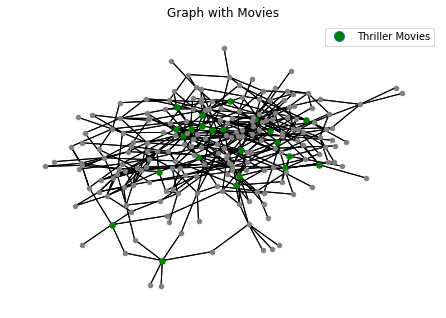

In [53]:
# Identify movies in the 'Action' genre
movies = [node for node in G0.nodes() if movies_H.get(node) and 'Thriller' in movies_H[node]]

# Separate movies into 'Action' and other genres for plotting
movies_nodes = [node for node in G0.nodes() if node in movies]
other_movies_nodes = [node for node in G0.nodes() if node not in movies]

nx.draw(G0, pos, nodelist=movies_nodes, node_color='green', node_size=30)
nx.draw(G0, pos, nodelist=other_movies_nodes, node_color='gray', node_size=20)

plt.title('Graph with Movies')
plt.legend(handles=[plt.Line2D([], [], linestyle='', marker='o', markersize=10, markerfacecolor='green', label='Thriller Movies')])

plt.show()

In [54]:
# Identify movies in the genre
movies = [node for node in G0.nodes() if movies_H.get(node) and 'Horror' in movies_H[node]]

# Separate movies into 'Action' and other genres for plotting
movies_nodes = [node for node in G0.nodes() if node in movies]
other_movies_nodes = [node for node in G0.nodes() if node not in movies]

nx.draw(G0, pos, nodelist=movies_nodes, node_color='lightblue', node_size=30)
nx.draw(G0, pos, nodelist=other_movies_nodes, node_color='gray', node_size=20)

plt.title('Graph with Movies')
plt.legend(handles=[plt.Line2D([], [], linestyle='', marker='o', markersize=10, markerfacecolor='lightblue', label='Horror Movies')])

plt.show()

In [55]:
# Identify movies in the genre
movies = [node for node in G0.nodes() if movies_H.get(node) and 'Fantasy' in movies_H[node]]

# Separate movies into 'Action' and other genres for plotting
movies_nodes = [node for node in G0.nodes() if node in movies]
other_movies_nodes = [node for node in G0.nodes() if node not in movies]

nx.draw(G0, pos, nodelist=movies_nodes, node_color='purple', node_size=30)
nx.draw(G0, pos, nodelist=other_movies_nodes, node_color='gray', node_size=20)

plt.title('Graph with Movies')
plt.legend(handles=[plt.Line2D([], [], linestyle='', marker='o', markersize=10, markerfacecolor='purple', label='Fantasy Movies')])

plt.show()

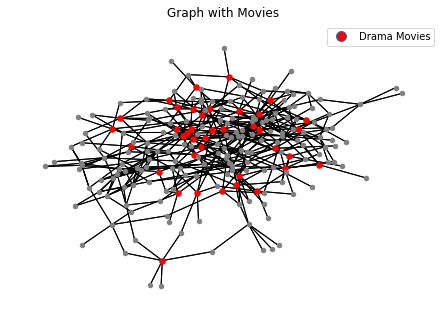

In [56]:
# Identify movies in the genre
movies = [node for node in G0.nodes() if movies_H.get(node) and 'Drama' in movies_H[node]]

# Separate movies into 'Action' and other genres for plotting
movies_nodes = [node for node in G0.nodes() if node in movies]
other_movies_nodes = [node for node in G0.nodes() if node not in movies]

nx.draw(G0, pos, nodelist=movies_nodes, node_color='red', node_size=30)
nx.draw(G0, pos, nodelist=other_movies_nodes, node_color='gray', node_size=20)

plt.title('Graph with Movies')
plt.legend(handles=[plt.Line2D([], [], linestyle='', marker='o', markersize=10, markerfacecolor='red', label='Drama Movies')])

plt.show()

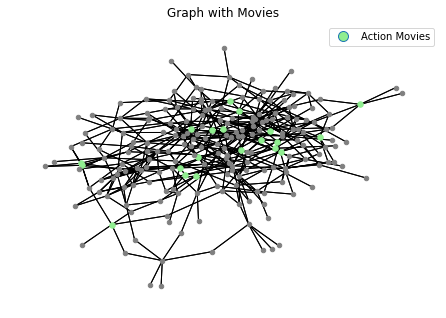

In [57]:
# Identify movies in the genre
movies = [node for node in G0.nodes() if movies_H.get(node) and 'Action' in movies_H[node]]

# Separate movies into 'Action' and other genres for plotting
movies_nodes = [node for node in G0.nodes() if node in movies]
other_movies_nodes = [node for node in G0.nodes() if node not in movies]

# Draw nodes for 'Action' genre movies and other movies with different attributes
nx.draw(G0, pos, nodelist=movies_nodes, node_color='lightgreen', node_size=30)
nx.draw(G0, pos, nodelist=other_movies_nodes, node_color='gray', node_size=20)

plt.title('Graph with Movies')
plt.legend(handles=[plt.Line2D([], [], linestyle='', marker='o', markersize=10, markerfacecolor='lightgreen', label='Action Movies')])

plt.show()

In [58]:
# Identify movies in the genre
movies = [node for node in G0.nodes() if movies_H.get(node) and 'Comedy' in movies_H[node]]

# Separate movies into 'Action' and other genres for plotting
movies_nodes = [node for node in G0.nodes() if node in movies]
other_movies_nodes = [node for node in G0.nodes() if node not in movies]

nx.draw(G0, pos, nodelist=movies_nodes, node_color='yellow', node_size=30)
nx.draw(G0, pos, nodelist=other_movies_nodes, node_color='gray', node_size=20, width=0.1)

plt.title('Graph with Movies')
plt.legend(handles=[plt.Line2D([], [], linestyle='', marker='o', markersize=10, markerfacecolor='yellow', label='Comedy Movies')])

plt.show()

## 4.2 Movies Network Analysis

Let us perform centrality analysis on the Movies Network in order to identify the most influential movies in the network. We will consider the following centrality measures:

* Degree Centrality: measures the number of connections each node has. In our case, it shows how many actors each actor has worked with.
* Betweenness Centrality: measures the frequency at which a node appears on the shortest paths between other nodes. High betweenness centrality indicates an actor who connects different clusters or communities within the network.
* Closeness Centrality: measures how close a node is to all other nodes in the network. An actor with high closeness centrality can quickly interact with others in the network.

In [59]:
# Make list of genres
genres = {
    'Mystery': 0,
    'Thriller': 0,
    'Horror': 0,
    'Fantasy': 0,
    'Drama': 0,
    'Action': 0,
    'Comedy': 0
}

# Extract nodes from the largest connected component G0
nodes_in_largest_component = list(G0.nodes())

# Count nodes for each genre in the largest connected component
for node in nodes_in_largest_component:
    if node in movies_H:
        node_genres = movies_H[node]
        for genre in genres:
            if genre in node_genres:
                genres[genre] += 1

# Sort genres by node count in descending order
sorted_genres = {k: v for k, v in sorted(genres.items(), key=lambda item: item[1], reverse=True)}

# Display the count of nodes for each genre in descending order
for genre, count in sorted_genres.items():
    print(f"{genre}: {count} nodes")

# Find the most represented genre in the largest connected component
most_represented_genre = max(sorted_genres, key=sorted_genres.get)
print(f"The most represented genre in the largest connected component is: {most_represented_genre} ({sorted_genres[most_represented_genre]} nodes)")


Drama: 39 nodes
Thriller: 23 nodes
Action: 20 nodes
Comedy: 18 nodes
Fantasy: 15 nodes
Mystery: 4 nodes
Horror: 2 nodes
The most represented genre in the largest connected component is: Drama (39 nodes)


Analizing the graph we can see that drama is the genre with the most nodes as it connects 42 nodes. Followed up by thriller with 25 nodes and action with 21 nodes. It is important to note that we are only observing the 6 most represented genres in the network, hence why we do not observe the distribution over all genres. Hence, giving us an overview of the genre pattern distributions over the network.

In [60]:
# Basic Network Information
num_nodes = G0.number_of_nodes()
num_edges = G0.number_of_edges()
density = nx.density(G0)
connected_components = nx.number_connected_components(G0)
largest_cc = max(nx.connected_components(G0), key=len)
size_largest_cc = len(largest_cc)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Density of the network: {density}")
print(f"Number of connected components: {connected_components}")
print(f"Size of the largest connected component: {size_largest_cc}")

# Centralities
degree_centrality = nx.degree_centrality(G0)
top_degree_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:5]

betweenness_centrality = nx.betweenness_centrality(G0)
top_betweenness_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:5]

closeness_centrality = nx.closeness_centrality(G0)
top_closeness_nodes = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)[:5]

print(f"Top 5 nodes by degree centrality: {top_degree_nodes}")
print(f"Top 5 nodes by betweenness centrality: {top_betweenness_nodes}")
print(f"Top 5 nodes by closeness centrality: {top_closeness_nodes}")

# Community Detection
communities = nx.algorithms.community.greedy_modularity_communities(G0)
num_communities = len(communities)
modularity = nx.algorithms.community.quality.modularity(G0, communities)

print(f"Number of communities: {num_communities}")
print(f"Modularity: {modularity}")

# Path Analysis
average_shortest_path_length = nx.average_shortest_path_length(G0)
diameter = nx.diameter(G0)

print(f"Average shortest path length: {average_shortest_path_length}")
print(f"Diameter: {diameter}")

# Calculate Average Degree
average_degree = sum(dict(G0.degree()).values()) / num_nodes
print(f"Average degree: {average_degree}")

Number of nodes: 216
Number of edges: 422
Density of the network: 0.0181739879414298
Number of connected components: 1
Size of the largest connected component: 216


Top 5 nodes by degree centrality: ['Pulp Fiction', 'Philip Ettington', 'A Time to Kill', 'Boogie Nights', 'Gary Oldman']
Top 5 nodes by betweenness centrality: ['Samuel L. Jackson', 'Philip Ettington', 'Pulp Fiction', 'Gary Oldman', 'The Thin Red Line']
Top 5 nodes by closeness centrality: ['Philip Ettington', 'Samuel L. Jackson', 'Pulp Fiction', 'Gary Oldman', 'True Romance']
Number of communities: 11
Modularity: 0.5600980436198648
Average shortest path length: 4.423944875107666
Diameter: 8
Average degree: 3.9074074074074074


Analizing the graph we can see that we have a reduced total of $227$ nodes and $435$ edges. This is is the result of the largest component segmentation that isolates the most connected component of the connected nodes with highest degree centrality. This enables us to visualize the network of movie nodes and common actors as edges. The network has a rather low density value of $0.0169$ suggesting that it is not very interconnected, meaning that the movies do not share a large amount of actors. Each node has an average degree of $3.832$, meaning that there are around 4 actors per movie, where each performs in at least 5 movies to be considered. 

After the community analysis we have a total amount of 12 communities, which results into a modularity value of 0.5494. This means that the network is well split into its corresponding communities. A higher modularity value closer to one would suggest better separation between the communities, this could be the case when examining a much larger amount of the movie network.

In [61]:
# Calculate degree centrality for each node
degree_centralities = nx.degree_centrality(G0)

# Find the top nodes with highest degree centrality
top_degree_nodes = sorted(degree_centralities, key=degree_centralities.get, reverse=True)[:10]

print("Top 10 nodes with highest degree centrality:")
for node in top_degree_nodes:
    print(f"Node: {node}, Degree Centrality: {degree_centralities[node]}")

Top 10 nodes with highest degree centrality:
Node: Pulp Fiction, Degree Centrality: 0.046511627906976744
Node: Philip Ettington, Degree Centrality: 0.04186046511627907
Node: A Time to Kill, Degree Centrality: 0.037209302325581395
Node: Boogie Nights, Degree Centrality: 0.037209302325581395
Node: Gary Oldman, Degree Centrality: 0.037209302325581395
Node: The Thin Red Line, Degree Centrality: 0.037209302325581395
Node: Harry Potter and the Order of the Phoenix, Degree Centrality: 0.037209302325581395
Node: Warwick Davis, Degree Centrality: 0.037209302325581395
Node: Alan Rickman, Degree Centrality: 0.037209302325581395
Node: Samuel L. Jackson, Degree Centrality: 0.037209302325581395


Here we have displayed the movies with highest degree centralities. The Player is the movie with highest centrality value of 0.0431.